In [3]:
import fiftyone as fo
import fiftyone.utils.random as four
import fiftyone.zoo as foz
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
import os
import open3d as o3d
import numpy as np
from nuscenes.utils.geometry_utils import BoxVisibility, transform_matrix

nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

dataset = fo.Dataset("nuscenes", overwrite=True)
dataset.add_group_field("group", default="CAM_FRONT")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.472 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
def load_lidar(filepath):
    root, extension = os.path.splitext(filepath)

    if os.path.exists(root):
        return root
    else: 
        cloud = LidarPointCloud.from_file(filepath)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(cloud.points[:3,:].T)
        colors = np.row_stack([cloud.points[3, :], np.zeros(cloud.points.shape[1]), np.zeros(cloud.points.shape[1])]).T
        pcd.colors = o3d.utility.Vector3dVector(colors)

        o3d.io.write_point_cloud(root, pcd)

        return root


In [4]:
from nuscenes.utils.data_io import load_bin_file, panoptic_to_lidarseg
from nuscenes.utils.color_map import get_colormap
from nuscenes.lidarseg.lidarseg_utils import paint_points_label

def load_lidar2(lidar_token):

    gt_from = "lidarseg"
    lidarseg_filename = "/data/sets/nuscenes/" + nusc.get(gt_from, lidar_token)['filename']
    points_label = load_bin_file(lidarseg_filename, type=gt_from)
    colormap = get_colormap()
    name2index = nusc.lidarseg_name2idx_mapping

    coloring = paint_points_label(lidarseg_filename,None,name2index, colormap=colormap)
    filepath = "/data/sets/nuscenes/" + nusc.get("sample_data", lidar_token)['filename']
    root, extension = os.path.splitext(filepath)

    cloud = LidarPointCloud.from_file(filepath)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud.points[:3,:].T)
    colors = coloring[:,:3]
    colors.max()
    pcd.colors = o3d.utility.Vector3dVector(colors)

    o3d.io.write_point_cloud(root, pcd)

    return root



In [7]:



groups = ["CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT", "CAM_BACK",
           "CAM_BACK_LEFT", "CAM_FRONT_LEFT","LIDAR_TOP", "RADAR_FRONT",
           "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]

samples = []
for scene in nusc.scene:
    my_scene = scene
    token = my_scene['first_sample_token']
    my_sample = nusc.get('sample', token)
    last_sample_token = my_scene['last_sample_token']
    

    
    while not my_sample["next"] == "":
        scene_token = my_sample["scene_token"]
        lidar_token = my_sample["data"]["LIDAR_TOP"]
        group = fo.Group()
        for sensor in groups:
            data = nusc.get('sample_data', my_sample['data'][sensor])
            filepath = "/data/sets/nuscenes/" + data["filename"]
            if data["sensor_modality"] == "lidar":
                filepath = load_lidar2(lidar_token)
            sample = fo.Sample(filepath=filepath, group=group.element(sensor))
            sample["token"] = data["token"]
            sample["ego_pose_token"] = data["ego_pose_token"]
            sample["calibrated_sensor_token"] = data["calibrated_sensor_token"]
            sample["timestamp"] = data["timestamp"]
            sample["is_key_frame"] = data["is_key_frame"]
            sample["prev"] = data["prev"]
            sample["next"] = data["next"]
            sample["scene_token"] = scene_token

            detections = []
            for ann_token in my_sample["anns"]:
                _, box, _ = nusc.get_sample_data(lidar_token, box_vis_level=BoxVisibility.NONE,
                                                                        selected_anntokens=[ann_token])
                ann = nusc.get('sample_annotation', ann_token)
                
                x, y, z = box[0].orientation.yaw_pitch_roll
                w, l, h = box[0].wlh.tolist()
            #print(x, y, z)

                detection = fo.Detection(
                        label=ann['category_name'],
                        location=box[0].center.tolist(),
                        rotation=[z, y, x],
                        dimensions=[l,w,h]
                        )
                detections.append(detection)
            
            sample["ground_truth"] = fo.Detections(detections=detections)
            samples.append(sample)

        token = my_sample["next"]

        my_sample = nusc.get('sample', token)
    break



        
dataset.add_samples(samples)

 100% |█████████████████| 456/456 [13.8s elapsed, 0s remaining, 35.0 samples/s]      


['65021b3a03df9be7b77859cf',
 '65021b3a03df9be7b77859d0',
 '65021b3a03df9be7b77859d1',
 '65021b3a03df9be7b77859d2',
 '65021b3a03df9be7b77859d3',
 '65021b3a03df9be7b77859d4',
 '65021b3a03df9be7b77859d5',
 '65021b3a03df9be7b77859d6',
 '65021b3a03df9be7b77859d7',
 '65021b3a03df9be7b77859d8',
 '65021b3a03df9be7b77859d9',
 '65021b3a03df9be7b77859da',
 '65021b3a03df9be7b77859db',
 '65021b3a03df9be7b77859dc',
 '65021b3a03df9be7b77859dd',
 '65021b3b03df9be7b77859de',
 '65021b3b03df9be7b77859df',
 '65021b3b03df9be7b77859e0',
 '65021b3b03df9be7b77859e1',
 '65021b3b03df9be7b77859e2',
 '65021b3b03df9be7b77859e3',
 '65021b3b03df9be7b77859e4',
 '65021b3b03df9be7b77859e5',
 '65021b3b03df9be7b77859e6',
 '65021b3b03df9be7b77859e7',
 '65021b3b03df9be7b77859e8',
 '65021b3b03df9be7b77859e9',
 '65021b3b03df9be7b77859ea',
 '65021b3b03df9be7b77859eb',
 '65021b3b03df9be7b77859ec',
 '65021b3b03df9be7b77859ed',
 '65021b3b03df9be7b77859ee',
 '65021b3b03df9be7b77859ef',
 '65021b3b03df9be7b77859f0',
 '65021b3b03df

In [5]:
print(dataset)

Name:        nuscenes
Media type:  group
Group slice: CAM_FRONT
Num groups:  38
Persistent:  False
Tags:        []
Sample fields:
    id:                      fiftyone.core.fields.ObjectIdField
    filepath:                fiftyone.core.fields.StringField
    tags:                    fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    group:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.groups.Group)
    token:                   fiftyone.core.fields.StringField
    ego_pose_token:          fiftyone.core.fields.StringField
    calibrated_sensor_token: fiftyone.core.fields.StringField
    timestamp:               fiftyone.core.fields.IntField
    is_key_frame:            fiftyone.core.fields.BooleanField
    prev:                    fiftyone.core.fields.StringField
    next:                    fiftyone.core.fields.StringField
    scene_tok

In [9]:
session = fo.launch_app(dataset)

 100% |███████████████████| 38/38 [372.9ms elapsed, 0s remaining, 101.9 samples/s]     



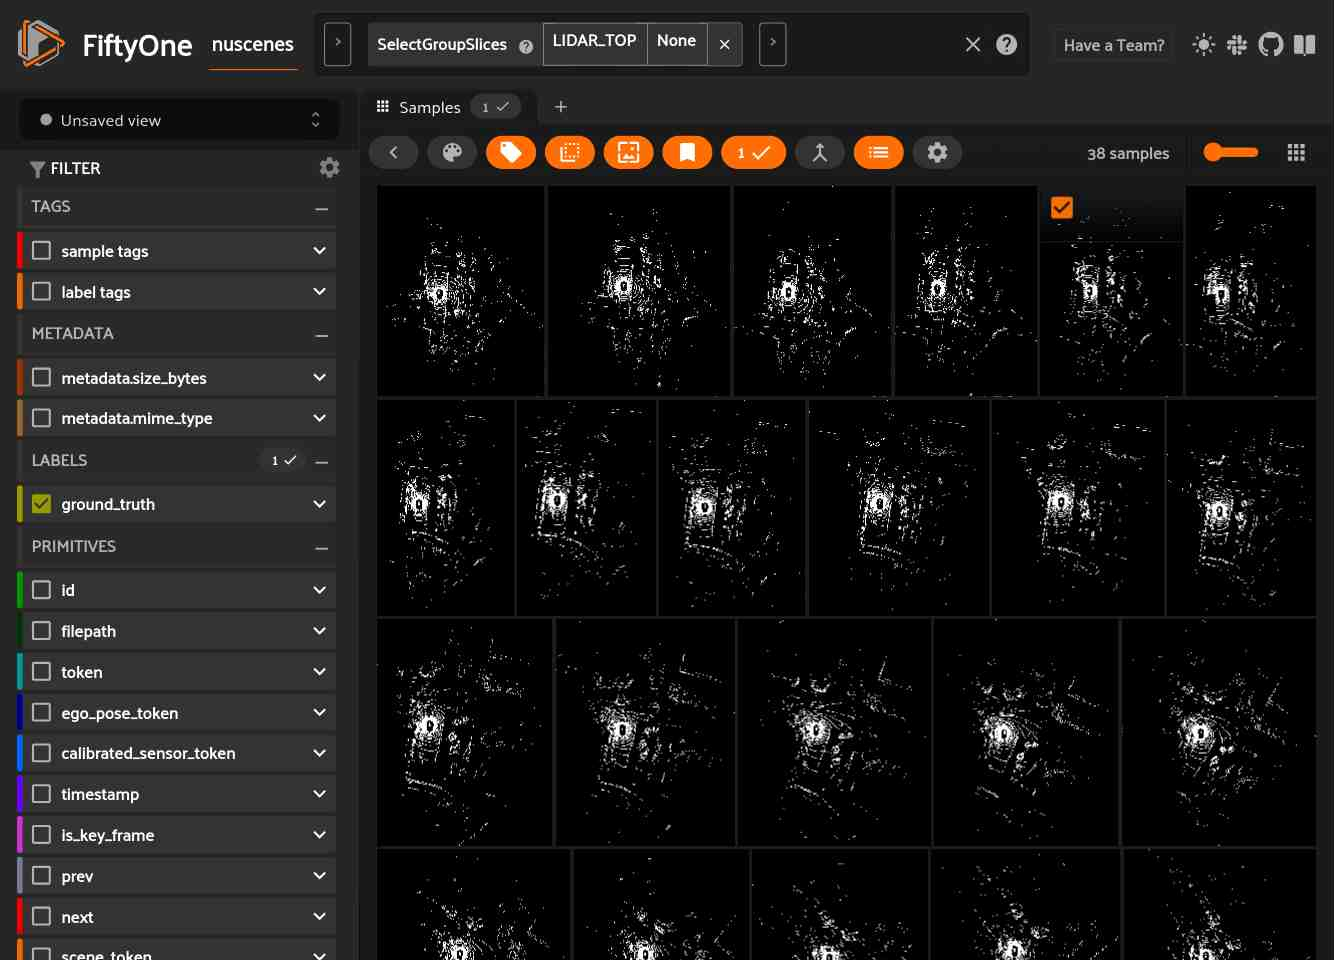

In [8]:
import fiftyone.utils.utils3d as fou3d

view = dataset.select_group_slices("LIDAR_TOP")

fou3d.compute_orthographic_projection_images(view, (-1, 512), "/tmp/proj")

session = fo.launch_app(view)

{'token': '39586f9d59004284a7114a68825e8eec',
 'timestamp': 1532402928147847,
 'prev': 'ca9a282c9e77460f8360f564131a8af5',
 'next': '356d81f38dd9473ba590f39e266f54e5',
 'scene_token': 'cc8c0bf57f984915a77078b10eb33198',
 'data': {'RADAR_FRONT': 'b70cefb08263499eb30c7e7da0031428',
  'RADAR_FRONT_LEFT': 'b5cd02b25f0944f19c0d123fa1fc54ec',
  'RADAR_FRONT_RIGHT': '9b628ce4952a4a839962b77a76630e23',
  'RADAR_BACK_LEFT': '28b610ada2b545d1a5a1bf9d08af0285',
  'RADAR_BACK_RIGHT': '07a62118eb3b43ffa1d833f250ff6f80',
  'LIDAR_TOP': '4f792c8da81e4cb7aca1790654da1c27',
  'CAM_FRONT': '4b6870ae200c4b969b91c50a9737f712',
  'CAM_FRONT_RIGHT': '5c026763ad8146e89c6ee53da26331dc',
  'CAM_BACK_RIGHT': 'c339f7629fdf4c219e30ca1790b53773',
  'CAM_BACK': '661d9842bbb44b208f867f2061c4f535',
  'CAM_BACK_LEFT': '9320f00a62c24b80972048de7a742b4c',
  'CAM_FRONT_LEFT': '2b9d52c5c777455eb31831860c6fc117'},
 'anns': ['7987617983634b119e383d8a29607fd7',
  '216bbbd8e01c450a8fabe9d47433c10a',
  'f0cbd9dbafd74e20bcf6dd0